# Neural-Fly: Domain Adversarially Invariant Meta Learning

This script loads quadrotor flight data in different wind conditions, trains a wind invariant representation of the unmodeled aerodynamics, and tests the performance of the model when adapting to new data in different wind conditions. 

## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.set_default_tensor_type('torch.DoubleTensor')
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split

import utils
import mlmodel

/opt/miniconda3/envs/neuralfly/lib/python3.13/site-packages/torch/__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_626md4ifaq/croot/libtorch_1738971453702/work/torch/csrc/tensor/python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


In [2]:
import sys
if sys.platform == 'win32':
    NUM_WORKERS = 0 # Windows does not support multiprocessing
else:
    NUM_WORKERS = 2
print('running on ' + sys.platform + ', setting ' + str(NUM_WORKERS) + ' workers')

running on darwin, setting 2 workers


## Load the data and create some simple visualizations

In [3]:
import os

dim_a = 3
features = ['v', 'q', 'pwm']
label = 'fa'

# Training data collected from the neural-fly drone
dataset = 'hw2sim' 
dataset_folder = 'data/custom'

# Read all the dataset files starting with 'data' and ending with '.npy'
Data = []
TestData = []
C = 0
for file in os.listdir(dataset_folder):
    if file.startswith('data') and file.endswith('.npy'):
        data_path = os.path.join(dataset_folder, file)
        # print(data_path)
        data = np.load(data_path, allow_pickle=True)
        train_data, test_data = random_split(data, [int(0.8 * len(data)), len(data) - int(0.8 * len(data))])
        train_data = train_data.dataset
        test_data = test_data.dataset
        data_dict = {}
        data_dict['X'] = train_data[:, :-3]
        data_dict['Y'] = train_data[:, -3:]
        data_dict['C'] = C
        test_data_dict = {}
        test_data_dict['X'] = test_data[:, :-3]
        test_data_dict['Y'] = test_data[:, -3:]
        test_data_dict['C'] = C
        C += 1
        Data.append(data_dict)
        TestData.append(test_data_dict)
        
print(f"Loaded {len(Data)} datasets from {dataset_folder}")

modelname = f"{dataset}_dim-a-{dim_a}_{'-'.join(features)}" # 'intel-aero_fa-num-Tsp_v-q-pwm'

Loaded 9 datasets from data/custom


In [4]:
# # Data variable indices in X
# V_0_IDX = 0
# V_1_IDX = 1
# V_2_IDX = 2
# Q_0_IDX = 3
# Q_1_IDX = 4
# Q_2_IDX = 5
# Q_3_IDX = 6
# PWM_0_IDX = 7
# PWM_1_IDX = 8
# PWM_2_IDX = 9
# PWM_3_IDX = 10

# # Data variable indices in Y
# FA_X_IDX = 11
# FA_Y_IDX = 12
# FA_Z_IDX = 13

## Initialize some other hyperparameters

In [5]:
options = {}
options['dim_x'] = Data[0]['X'].shape[1]
options['dim_y'] = Data[0]['Y'].shape[1]
options['num_c'] = len(Data)
print('dims of (x, y) are', (options['dim_x'], options['dim_y']))
print('there are ' + str(options['num_c']) + ' different conditions')

dims of (x, y) are (11, 3)
there are 9 different conditions


In [6]:
# Set hyperparameters
options['features'] = features
options['dim_a'] = dim_a
options['loss_type'] = 'crossentropy-loss'

options['shuffle'] = True # True: shuffle trajectories to data points
options['K_shot'] = 32 # number of K-shot for least square on a
options['phi_shot'] = 256 # batch size for training phi

options['alpha'] = 0.01 # adversarial regularization loss
options['learning_rate'] = 5e-4
options['frequency_h'] = 2 # how many times phi is updated between h updates, on average
options['SN'] = 2. # maximum single layer spectral norm of phi
options['gamma'] = 10. # max 2-norm of a
options['num_epochs'] = 1000

# Dataset Generation

The adaptation dataset will be used to update $a$ in each training loop.
The training dataset will be used to train $\phi$ in each training loop.

In [7]:
# Trainset = []
# Adaptset = []
Trainloader = []
Adaptloader = []
for i in range(options['num_c']):
    fullset = mlmodel.MyDataset(Data[i]['X'], Data[i]['Y'], Data[i]['C'])
    
    l = len(Data[i]['X'])
    if options['shuffle']:
        trainset, adaptset = random_split(fullset, [int(2/3*l), l-int(2/3*l)])
    else:
        trainset = mlmodel.MyDataset(Data[i]['X'][:int(2/3*l)], Data[i]['Y'][:int(2/3*l)], Data[i]['C']) 
        adaptset = mlmodel.MyDataset(Data[i]['X'][int(2/3*l):], Data[i]['Y'][int(2/3*l):], Data[i]['C'])

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=options['phi_shot'], shuffle=options['shuffle'], num_workers=NUM_WORKERS)
    adaptloader = torch.utils.data.DataLoader(adaptset, batch_size=options['K_shot'], shuffle=options['shuffle'], num_workers=NUM_WORKERS)
   
    # Trainset.append(trainset)
    # Adaptset.append(adaptset)
    Trainloader.append(trainloader) # for training phi
    Adaptloader.append(adaptloader) # for LS on a

# Domain Adversarially Invariant Meta Learning

Assume the state $x\in\mathbb{R}^n$ and $c$ is hidden state used to represent changing environment. We are interested in learning some function $f(x(t),c(t))$. $f(x(t),c(t))$ can be separated into three terms: $$f(x(t),c(t))=\phi(x(t))a(c(t))+d(t),$$
where $\phi(x(t))$ captures the $c$-variant part and $a(c(t))\in\mathbb{R}^m$ is implicitly a function of the hidden state $c(t)$. Finally, $d(t)$ is the residual noise term.

We want to learn $\phi(x)$ such that it doesn't include any information about $c$. To reach this goal, we introduce another neural network $h$ where $h(\phi(x))$ tries to predict $c$.

The loss function is given as
$$\max_h\min_{\phi, \left\{a_{c_j}\right\}_j}\sum_{j}\sum_{i}\left\|\phi(x^{(i)}_{c_j})a_{c_j}-f(x^{(i)}_{c_j},c_j)\right\|^2-\alpha\cdot\text{CrossEntropy}\left(h(\phi(x^{(i)}_{c_j})),j\right)$$
Note that the $\text{CrossEntropy-loss}$ will not require physical encoding of $c_j$ in training, only a label for $c$ that corresponds to the subdataset (that is, the label $c$ has no physical meaning).

# Initialize the models

In [8]:
# Store the model class definition in an external file so they can be referenced outside this script
phi_net = mlmodel.Phi_Net(options)
h_net = mlmodel.H_Net_CrossEntropy(options)

In [9]:
criterion = nn.MSELoss()
criterion_h = nn.CrossEntropyLoss()
optimizer_h = optim.Adam(h_net.parameters(), lr=options['learning_rate'])
optimizer_phi = optim.Adam(phi_net.parameters(), lr=options['learning_rate'])

# Meta-Training Algorithm

**Step 0: sample $c$, and sample $B+K$ data points in correponding subdataset $\{x_i,c,f(x_i,c)\}_{i}$**

**Step 1: estimate $a$ using least-square**

$K$ data points (sampled from the same wind condition $c$) are used to compute $a$ using least-squares, i.e., adaptation:
$$
\underbrace{
    \begin{bmatrix}
        \phi(x_1) \\ \phi(x_2) \\ \vdots \\ \phi(x_K) 
    \end{bmatrix}}
    _{\Phi\in\mathbb{R}^{K\times \dim(a)}}
\cdot
\underbrace{
    \begin{bmatrix}
        a_1 & \cdots & a_{\dim(y)} 
    \end{bmatrix}}
    _{a\in\mathbb{R}^{\dim(a)\times \dim(y)}}
=
\underbrace{
    \begin{bmatrix}
        f_1(x_1) & \cdots & f_{\dim(y)}(x_1) \\ f_1(x_2) & \cdots & f_{\dim(y)}(x_2) \\ \vdots & \vdots & \vdots\\ f_1(x_K) & \cdots & f_{\dim(y)}(x_K) 
    \end{bmatrix}}
    _{Y\in\mathbb{R}^{K\times \dim(y)}}
$$

The least square solution is given by
$$a=(\Phi^\top\Phi)^{-1}\Phi^\top Y$$
Normalization on $a$ is implemented to avoid ambiguity of $\phi(x)a$ (since $\phi(x)a=(0.1\phi(x))\cdot(10a)$):
$$a\leftarrow \gamma\cdot\frac{a}{\|a\|_F},\quad\text{if}\,\,\|a\|_F>\gamma$$
Note that $a$ is an implicit function of $\phi$.

**Step 2: fix $h$ and train $\phi$**

With this $a$, another $B$ data points (with same $c$) are used for gradient descent with loss
$$\mathcal{L}(\phi)=\|f(x)-\phi(x)a\|_2^2-\alpha\cdot\|h(\phi(x))-c\|_2^2$$

**Step 3: fix $\phi$ and train discriminator $h$**

Finally, these $B$ data points are used again for gradient descent on $h$ with loss
$$\mathcal{L}(h)=\|h(\phi(x))-c\|_2^2$$
We may run this step less frequently than step 2, to improve stability in training (a trick from GAN).

In [ ]:
from tqdm import tqdm

model_save_freq = 50 # How often to save the model

# Create some arrays to save training statistics
Loss_f = [] # combined force prediction loss
Loss_c = [] # combined adversarial loss

# Loss for each subdataset 
Loss_test_nominal = [] # loss without any learning
Loss_test_mean = [] # loss with mean predictor
Loss_test_phi = [] # loss with NN
for i in range(len(TestData)):
    Loss_test_nominal.append([])
    Loss_test_mean.append([])
    Loss_test_phi.append([])

# Training!
for epoch in tqdm(range(options['num_epochs']), desc="Training Epochs"):
    # Randomize the order in which we train over the subdatasets
    arr = np.arange(options['num_c'])
    np.random.shuffle(arr)

    # Running loss over all subdatasets
    running_loss_f = 0.0
    running_loss_c = 0.0

    for i in arr:
        with torch.no_grad():
            adaptloader = Adaptloader[i]
            kshot_data = next(iter(adaptloader))
            trainloader = Trainloader[i]
            data = next(iter(trainloader))
        
        optimizer_phi.zero_grad()
        
        '''
        Least-square to get $a$ from K-shot data
        '''
        X = kshot_data['input'] # K x dim_x
        Y = kshot_data['output'] # K x dim_y
        Phi = phi_net(X) # K x dim_a
        Phi_T = Phi.transpose(0, 1) # dim_a x K
        A = torch.inverse(torch.mm(Phi_T, Phi)) # dim_a x dim_a
        a = torch.mm(torch.mm(A, Phi_T), Y) # dim_a x dim_y
        if torch.norm(a, 'fro') > options['gamma']:
            a = a / torch.norm(a, 'fro') * options['gamma']
            
        '''
        Batch training \phi_net
        '''
        inputs = data['input'] # B x dim_x
        labels = data['output'] # B x dim_y
        
        c_labels = data['c'].type(torch.long)
            
        # forward + backward + optimize
        outputs = torch.mm(phi_net(inputs), a)
        loss_f = criterion(outputs, labels)
        temp = phi_net(inputs)
        
        loss_c = criterion_h(h_net(temp), c_labels)
            
        loss_phi = loss_f - options['alpha'] * loss_c
        loss_phi.backward()
        optimizer_phi.step()
        
        '''
        Discriminator training
        '''
        if np.random.rand() <= 1.0 / options['frequency_h']:
            optimizer_h.zero_grad()
            temp = phi_net(inputs)
            
            loss_c = criterion_h(h_net(temp), c_labels)
            
            loss_h = loss_c
            loss_h.backward()
            optimizer_h.step()
        
        '''
        Spectral normalization
        '''
        if options['SN'] > 0:
            for param in phi_net.parameters():
                M = param.detach().numpy()
                if M.ndim > 1:
                    s = np.linalg.norm(M, 2)
                    if s > options['SN']:
                        param.data = param / s * options['SN']
         
        running_loss_f += loss_f.item()
        running_loss_c += loss_c.item()
    
    # Save statistics
    Loss_f.append(running_loss_f / options['num_c'])
    Loss_c.append(running_loss_c / options['num_c'])
    if epoch % 10 == 0:
        print('[%d] loss_f: %.2f loss_c: %.2f' % (epoch + 1, running_loss_f / options['num_c'], running_loss_c / options['num_c']))

        
    with torch.no_grad():
        for j in range(len(TestData)):
            loss_nominal, loss_mean, loss_phi = mlmodel.error_statistics(TestData[j]['X'], TestData[j]['Y'], phi_net, h_net, options=options)
            Loss_test_nominal[j].append(loss_nominal)
            Loss_test_mean[j].append(loss_mean)
            Loss_test_phi[j].append(loss_phi)

    if epoch % model_save_freq == 0:
        mlmodel.save_model(phi_net=phi_net, h_net=h_net, modelname=modelname + '-epoch-' + str(epoch), options=options)

<>:49: SyntaxWarning: invalid escape sequence '\p'
<>:49: SyntaxWarning: invalid escape sequence '\p'
/var/folders/xr/smwtgd4n7zs6_vpwrvw58_m40000gn/T/ipykernel_74055/3954521224.py:49: SyntaxWarning: invalid escape sequence '\p'
  '''
Training Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]/opt/miniconda3/envs/neuralfly/lib/python3.13/site-packages/torch/__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_626md4ifaq/croot/libtorch_1738971453702/work/torch/csrc/tensor/python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)
/opt/miniconda3/envs/neuralfly/lib/python3.13/site-packages/torch/__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Trigger

[1] loss_f: 0.27 loss_c: 2.23


Training Epochs:   0%|          | 1/1000 [02:42<45:04:38, 162.44s/it]/opt/miniconda3/envs/neuralfly/lib/python3.13/site-packages/torch/__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_626md4ifaq/croot/libtorch_1738971453702/work/torch/csrc/tensor/python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)
/opt/miniconda3/envs/neuralfly/lib/python3.13/site-packages/torch/__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_626md4ifaq/croot/libtorch_1738971453702/work/torch/csrc/tensor/python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)
/opt/miniconda3/envs/neur

[11] loss_f: 0.24 loss_c: 2.22


Training Epochs:   1%|          | 11/1000 [29:34<44:14:52, 161.06s/it]/opt/miniconda3/envs/neuralfly/lib/python3.13/site-packages/torch/__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_626md4ifaq/croot/libtorch_1738971453702/work/torch/csrc/tensor/python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)
/opt/miniconda3/envs/neuralfly/lib/python3.13/site-packages/torch/__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_626md4ifaq/croot/libtorch_1738971453702/work/torch/csrc/tensor/python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)
/opt/miniconda3/envs/neu

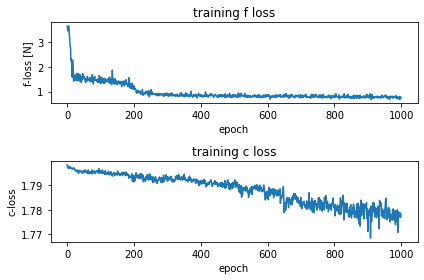

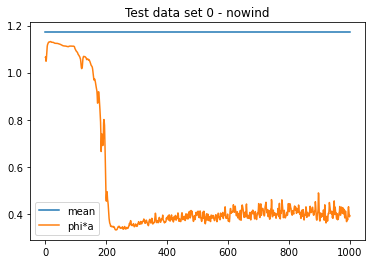

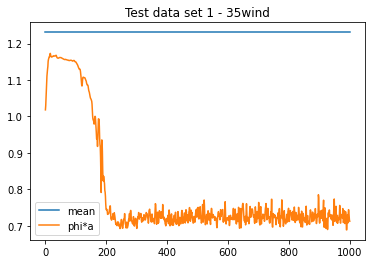

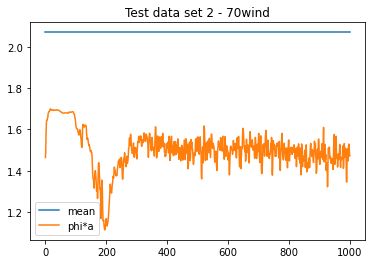

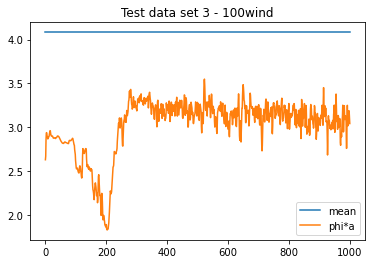

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(Loss_f)
plt.xlabel('epoch')
plt.ylabel('f-loss [N]')
plt.title('training f loss')
plt.subplot(2, 1, 2)
plt.plot(Loss_c)
plt.title('training c loss')
plt.xlabel('epoch')
plt.ylabel('c-loss')
plt.tight_layout()

for j in range(len(TestData)):
    plt.figure()
    # plt.plot(Loss_test_nominal[j], label='nominal')
    plt.plot(Loss_test_mean[j], label='mean')
    plt.plot(np.array(Loss_test_phi[j]), label='phi*a')
    # plt.plot(np.array(Loss_test_exp_forgetting[j]), label='exp forgetting')
    plt.legend()
    plt.title(f'Test data set {j} - {TestData[j].meta["condition"]}')

plt.show()

In [ ]:
# Choose final model
stopping_epoch = 200
options['num_epochs'] = stopping_epoch
final_model = mlmodel.load_model(modelname = modelname + '-epoch-' + str(stopping_epoch))

# Error Analysis

Plot the measured aerodynamic force, labeled ground truth (gt), along with the region used for adapation (adapt), and the predicted region (val)

------------------------------
10wind:
a = [[ 0.98646929  0.53218362  6.55730863]
 [ 2.11169188 -0.02214385 -2.51523472]
 [-0.15677477 -0.66144551 -4.44584517]]
|a| = 8.675736508178904


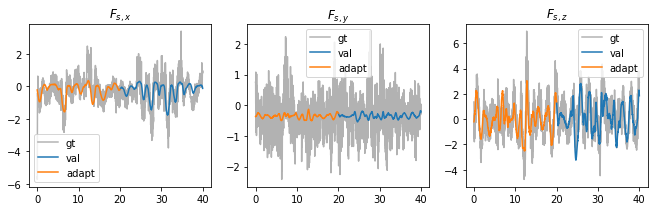

------------------------------
20wind:
a = [[ 0.46545883  0.1284584   3.65272849]
 [ 4.2798931  -0.24772016 -1.58418647]
 [ 0.1181721  -0.66150772 -2.70476232]]
|a| = 6.498566934693798


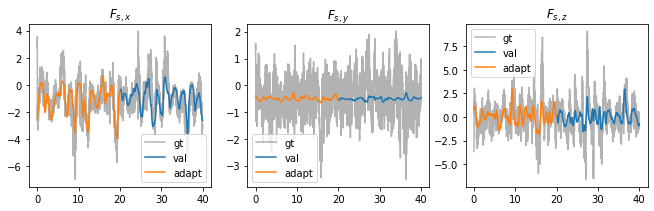

------------------------------
30wind:
a = [[ 1.55181628 -0.64765671  6.91513572]
 [ 5.72120667  0.01818594 -2.23687178]
 [-1.69906784  0.07633363 -4.18525523]]
|a| = 10.430332997890515


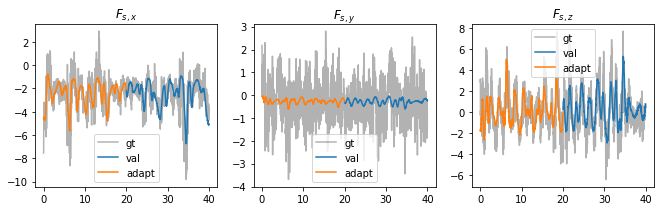

------------------------------
40wind:
a = [[ 1.30897041 -0.98188446  4.59463665]
 [ 4.19119633 -1.02368961 -3.03881971]
 [-3.185357   -0.13785578 -3.07336998]]
|a| = 8.440840321183472


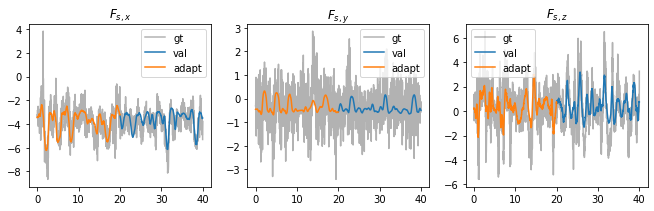

------------------------------
50wind:
a = [[ 1.15517318 -1.16544818  6.32766465]
 [ 5.61441966 -0.11782441 -4.17057315]
 [-4.27442938  0.17163325 -4.46263756]]
|a| = 11.396343450374008


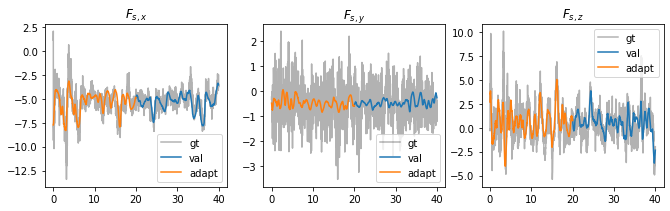

------------------------------
nowind:
a = [[ 1.23851476 -1.07435451  4.05514559]
 [ 3.06882222 -0.63885917 -1.09556085]
 [ 1.31318888  0.11330193 -2.14656647]]
|a| = 6.04181070354226


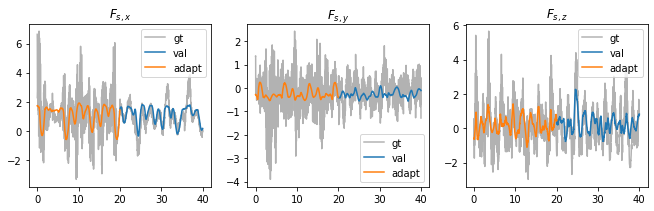

In [ ]:
for i, data in enumerate(Data):
    print('------------------------------')
    print(data.meta['condition'] + ':')
    mlmodel.vis_validation(t=data.meta['t'], x=data['X'], y=data['Y'], phi_net=final_model.phi, h_net=final_model.h, idx_adapt_start=0, idx_adapt_end=1000, idx_val_start=1000, idx_val_end=2000, c=Data[i]['C'], options=options)

In [ ]:
for data in Data:
    error_1, error_2, error_3 = mlmodel.error_statistics(data['X'], data['Y'], final_model.phi, final_model.h, options=options)
    print('**** c =', str(data['C']), ':', data.meta['condition'], '****')
    print(f'Before learning: MSE is {error_1: .2f}')
    print(f'Mean predictor: MSE is {error_2: .2f}')
    print(f'After learning phi(x): MSE is {error_3: .2f}')
    print('')

**** c = 0 : 10wind ****
Before learning: MSE is  1.20
Mean predictor: MSE is  1.14
After learning phi(x): MSE is  0.78

**** c = 1 : 20wind ****
Before learning: MSE is  2.17
Mean predictor: MSE is  1.68
After learning phi(x): MSE is  1.11

**** c = 2 : 30wind ****
Before learning: MSE is  3.58
Mean predictor: MSE is  1.76
After learning phi(x): MSE is  1.06

**** c = 3 : 40wind ****
Before learning: MSE is  6.69
Mean predictor: MSE is  1.91
After learning phi(x): MSE is  1.11

**** c = 4 : 50wind ****
Before learning: MSE is  11.41
Mean predictor: MSE is  2.03
After learning phi(x): MSE is  1.08

**** c = 5 : nowind ****
Before learning: MSE is  1.26
Mean predictor: MSE is  0.85
After learning phi(x): MSE is  0.58



## Test Data Error Analysis

------------------------------
nowind:
a = [[ 1.56149495 -0.07830581  6.34982413]
 [ 1.37586452  0.31432782 -2.57566705]
 [ 0.39020735 -0.33344144 -4.54982036]]
|a| = 8.506164882091928


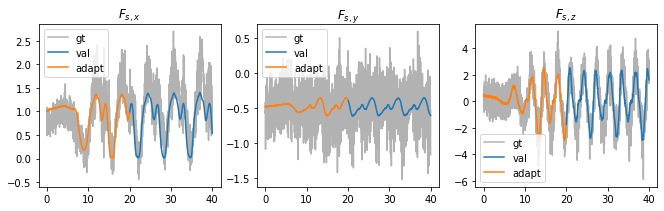

------------------------------
35wind:
a = [[ 0.76802851 -0.09541599  5.1339181 ]
 [ 2.41248586  0.10488627 -2.43051648]
 [-2.79288029 -0.34506057 -3.68485215]]
|a| = 7.758348345945585


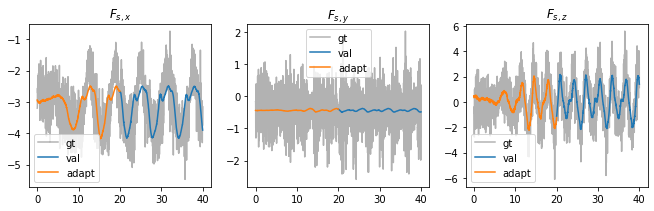

------------------------------
70wind:
a = [[ 2.11306562 -0.11624753  7.37683094]
 [ 3.9029527   0.11509771 -0.77064926]
 [-6.63749046 -0.28538269 -5.77127636]]
|a| = 12.336196164708998


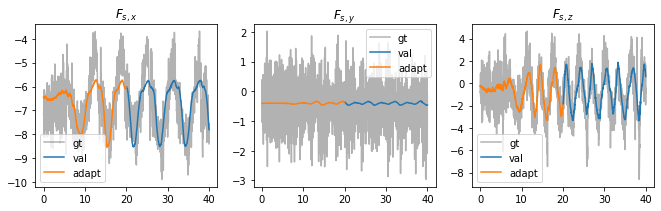

------------------------------
100wind:
a = [[  8.88195136  -0.39379331  11.17469557]
 [  5.0310497    0.54033022  -2.05834878]
 [-20.65852247  -0.30901595 -12.43813925]]
|a| = 28.55408064559192


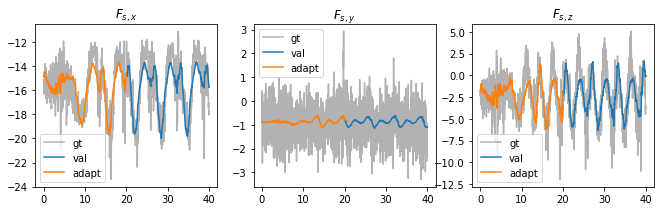

In [ ]:
for i, data in enumerate(TestData):
    print('------------------------------')
    print(data.meta['condition'] + ':')
    mlmodel.vis_validation(t=data.meta['t'], x=data['X'], y=data['Y'], phi_net=final_model.phi, h_net=final_model.h, idx_adapt_start=0, idx_adapt_end=1000, idx_val_start=1000, idx_val_end=2000, c=Data[i]['C'], options=options)

In [ ]:
for data in TestData:
    error_1, error_2, error_3 = mlmodel.error_statistics(data['X'], data['Y'], final_model.phi, final_model.h, options=options)
    print('**** :', data.meta['condition'], '****')
    print(f'Before learning: MSE is {error_1: .2f}')
    print(f'Mean predictor: MSE is {error_2: .2f}')
    print(f'After learning phi(x): MSE is {error_3: .2f}')
    print('')

**** : nowind ****
Before learning: MSE is  1.59
Mean predictor: MSE is  1.17
After learning phi(x): MSE is  0.45

**** : 35wind ****
Before learning: MSE is  4.61
Mean predictor: MSE is  1.23
After learning phi(x): MSE is  0.74

**** : 70wind ****
Before learning: MSE is  17.83
Mean predictor: MSE is  2.07
After learning phi(x): MSE is  1.17

**** : 100wind ****
Before learning: MSE is  87.63
Mean predictor: MSE is  4.08
After learning phi(x): MSE is  1.89

